I've been noticing that the lower -X dB frequency in virtual multi bat audio files are consistently lower than the single bat audio files. This is surprising, as the virtual multi bat audio files are actually supposed to be a kind of 'control' group to mimic the effect of what would happen if multiple bats flew in the same space without reacting to one another.

After a bunch of days of not being able to figrue out why this was the case, I finally may have found a possible cause - the fact that the power spectrum itself changes! In the observed multi bat audio files, it's typically one call sequence that dominates the audio. In a typical virtual multi bat audio file, both bats' calls are approximately the same level. This means, the power spectrum in a multi bat audio file will be very sharp and peaked, leading to higher lower frequencies. On the contrary, a virtual multi bat audio file's power spectrum will be more spread. Because it is more spread, the lower frequency will also be lower. 

In this notebook I will test the idea that the difference in lower frequency comes from the differene in the power spectra itself. The idea is to compare various aspects of the power spectrum itself.



- Author: Thejasvi Beleyur
- Date of notebook initiation: 2020-09-01


In [1]:
import glob
import sys 
sys.path.append('../')
sys.path.append('/home/tbeleyur/Documents/packages_dev/correct_call_annotations/')
import correct_call_annotations.correct_call_annotations as cca
import measure_annot_audio
from measure_annot_audio import inbuilt_measurement_functions as imf
import time
import datetime
import matplotlib.pyplot as plt 
import pandas as pd
import numpy  as np
import soundfile as sf
import tqdm


In [2]:
%matplotlib notebook

In [3]:
print(f'This notebook was run on {datetime.datetime.now()}')

This notebook was run on 2020-09-10 14:19:27.086565


## Overall audio spectra of the virtual multi bat files 
make the smoothed spectrum of the audio files. This will give us an idea of what each smaller snippet would actually look like, without having to actually go into the details of how each window looks like. 

In [4]:
v_multibatfiles = glob.glob('../virtual_multi_bat_audio/*.WAV')

In [5]:
keywords = {'inter_peak_difference':250, 
          'spectrum_smoothing_width': 100,
         'fs':250000}

In [6]:
def make_multi_audio_smoothed_spectra(audiofiles, **kwargs):
    '''
    Loads audio files and creates the smoothened power spectrum 
    
    Parameters
    ----------
    pref_channel : int>=0
        Preferred channel to load in case it is a multichannel file.
        Defaults to 0.
    
    Returns
    -------
    all_smoothed_spectra : list
        Each list entry is a tuple with 2 objects :(frequencies, smoothened power spectrum)
    
    See Also
    --------
    imf.make_smoothened_spectrum
    '''
    all_smoothed_spectra = []
    
    
    for each in tqdm.tqdm(audiofiles):
        audio, fs = sf.read(each)
        if sf.info(each).channels>1:
            pref_channel = kwargs.get('pref_channel', 0)
            audio = audio[:,pref_channel]
        smoothened_spectrum = imf.make_smoothened_spectrum(audio, **kwargs)
        freqs = freqs_audio = np.fft.rfftfreq(audio.size, 1.0/fs)
        all_smoothed_spectra.append((freqs, smoothened_spectrum))
    return all_smoothed_spectra

In [7]:
# smoothed spectra of virtual multi bat audio files 
virtual_multibat_spectra = make_multi_audio_smoothed_spectra(v_multibatfiles, **keywords)
    

100%|██████████| 121/121 [00:06<00:00, 17.34it/s]


In [8]:
# smoothed spectra of single bat audio files (used to make the virtual multi bat audio files)

# load the individual single bat audio files 
audio_files = pd.read_csv('../source_files_for_virtual_multibat_audio.csv')
all_singlebat_files = np.concatenate([each.split(',') for each in audio_files['source_single_bat_files']]).flatten()
# remove the single quotation mark from all filenames
all_singlebat_files = np.unique([each.replace("'","")for each in all_singlebat_files])
all_singlebat_files = np.unique([each.replace(" ","")for each in all_singlebat_files])

# get the actual location of each file
audio_folder = '../../individual_call_analysis/hp_annotation_audio/'
singlebat_files = [cca.find_file_in_folder(each, audio_folder)[0] for each in all_singlebat_files]

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!

In [9]:
single_bat_spectra = make_multi_audio_smoothed_spectra(singlebat_files, **keywords)

100%|██████████| 244/244 [00:19<00:00, 12.25it/s]


### Overall audio spectra of the observed multi bat files
Make the smoothed spectrum of the observed multi bat files. If my guess is correct, we will see that the observed multi bat files are actually much more 'peaked'.

In [10]:
def plot_smoothened_spectra_overlay(smoothed_spectra):
    for each in smoothed_spectra:    
        freqs, powerspec = each[0], each[1]
        norm_powerspec = powerspec-np.max(powerspec)
        plt.plot(freqs, norm_powerspec);

<IPython.core.display.Javascript object>


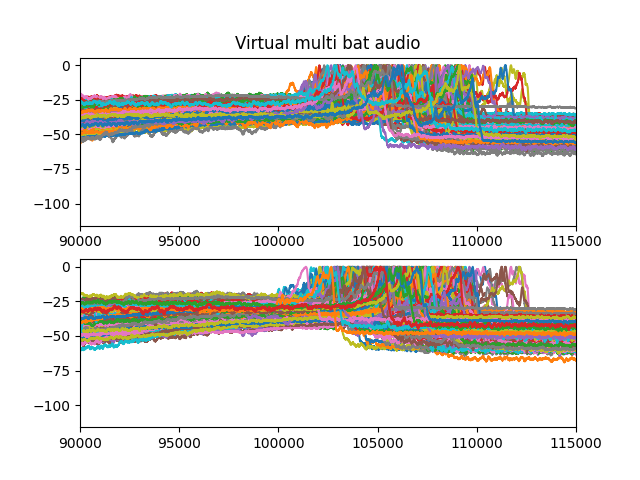

(90000.0, 115000.0)

In [11]:
plt.figure()
a0 = plt.subplot(211)
a0.set_title('Virtual multi bat audio')
plot_smoothened_spectra_overlay(virtual_multibat_spectra)
a0.set_xlim(90000,115000)
a1 = plt.subplot(212, sharex=a0, sharey=a0)
plot_smoothened_spectra_overlay(single_bat_spectra)
a1.set_xlim(90000,115000)

### Does the method of lower frequency calculation matter (using peak smoothed frequency OR raw peak frequency)
The overlaid spectra look somewhat similar - but what do the -46 dB lower frequency data say?


In [12]:
# taken and modified from the imf.lower_minusXdB_frequency
def lower_frequency(smooth_spectrum, freqs_audio, db_range, file_path,peak_with_smooth=True):
    
    if peak_with_smooth:
        peak_f = freqs_audio[np.argmax(smooth_spectrum)]
    else:
        channels= sf.info(file_path).channels
        audio, fs = sf.read(file_path)
        if channels>1:
            audio = audio[:,0]
        peak_f = imf.peak_frequency(audio, fs=fs)
    
    below_threshold = smooth_spectrum <= np.max(smooth_spectrum)-db_range
    freqs_below_threshold = freqs_audio[below_threshold]
    # choose only those frequencies that are below the peak frequencies.
    freqs_below_peak = freqs_below_threshold[freqs_below_threshold<peak_f]
    if len(freqs_below_peak) <1:
        return np.nan
    else:
        minus_XdB_frequency = np.max(freqs_below_peak)
        return minus_XdB_frequency

<IPython.core.display.Javascript object>


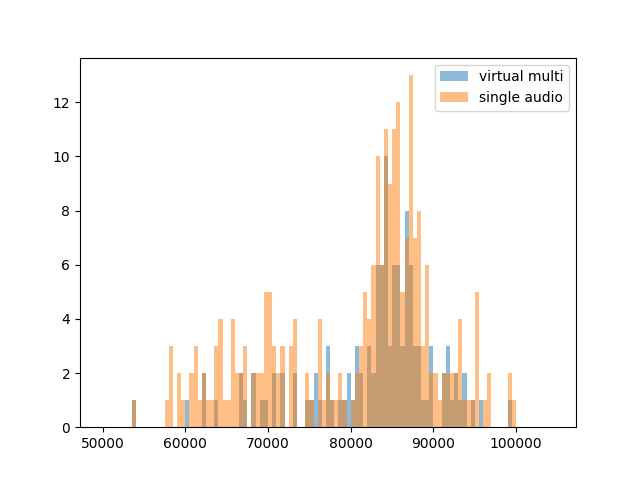

In [13]:
single_audio_lowerfreqs_1 = np.zeros(len(single_bat_spectra))
for i,(each, filepath) in enumerate(zip(single_bat_spectra, singlebat_files)):
    freqs, spectrum = each
    single_audio_lowerfreqs_1[i]=lower_frequency(spectrum, freqs, 46, file_path=filepath, peak_with_smooth=False)

vmulti_audio_lowerfreqs_1 = np.zeros(len(virtual_multibat_spectra))
for i, (each, filepath) in enumerate(zip(virtual_multibat_spectra, v_multibatfiles)):
    freqs, spec = each
    vmulti_audio_lowerfreqs_1[i] = lower_frequency(spec, freqs, 46,file_path=filepath, peak_with_smooth=False)
    
plt.figure()
plt.hist(vmulti_audio_lowerfreqs_1, alpha=0.5, label='virtual multi', bins=np.arange(50000,105000,500))
plt.hist(single_audio_lowerfreqs_1, alpha=0.5, label='single audio', bins=np.arange(50000,105000,500))
plt.legend()

<IPython.core.display.Javascript object>


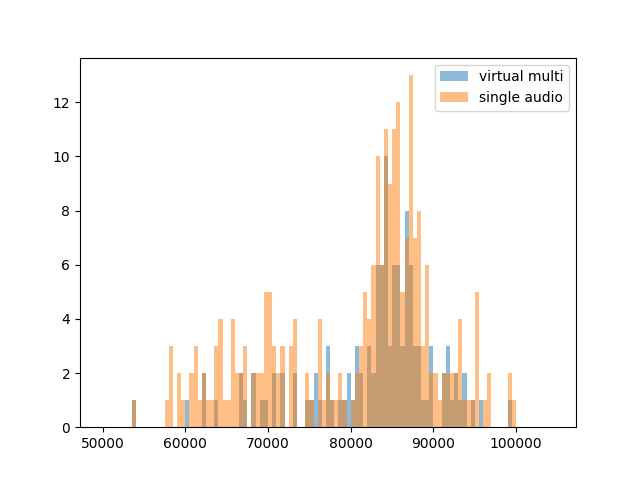

In [14]:
single_audio_lowerfreqs = np.zeros(len(single_bat_spectra))
for i,(each, filepath) in enumerate(zip(single_bat_spectra, singlebat_files)):
    freqs, spectrum = each
    single_audio_lowerfreqs[i]=lower_frequency(spectrum, freqs, 46, file_path=filepath, peak_with_smooth=True)

vmulti_audio_lowerfreqs = np.zeros(len(virtual_multibat_spectra))
for i, (each, filepath) in enumerate(zip(virtual_multibat_spectra, v_multibatfiles)):
    freqs, spec = each
    vmulti_audio_lowerfreqs[i] = lower_frequency(spec, freqs, 46,file_path=filepath, peak_with_smooth=True)
    
plt.figure()
plt.hist(vmulti_audio_lowerfreqs, alpha=0.5, label='virtual multi', bins=np.arange(50000,105000,500))
plt.hist(single_audio_lowerfreqs, alpha=0.5, label='single audio',bins=np.arange(50000,105000,500))
plt.legend()

In [15]:
single_audio_lowerfreqs[:10]

array([86495.19230769, 85377.77777778, 93606.25      , 83465.90909091,
       83653.94736842, 63278.84615385, 87082.92682927, 75077.88461538,
       96906.52173913, 79491.41791045])

In [16]:
single_audio_lowerfreqs_1[:10]

array([86495.19230769, 85377.77777778, 93606.25      , 83465.90909091,
       83653.94736842, 63278.84615385, 87082.92682927, 75077.88461538,
       96906.52173913, 79491.41791045])

The analyses above seem to indicate that there is no difference in the lower frequencies reported while using the peak frequency in the raw spectrum vs the peak frequency from the smoothened spectrum. It does match what I'd intuitively expect, but the fact is also that here we're dealing with long audio clips, and this is very different from the short 50ms long audio. However, I'm still not sure where the problem is.

<IPython.core.display.Javascript object>


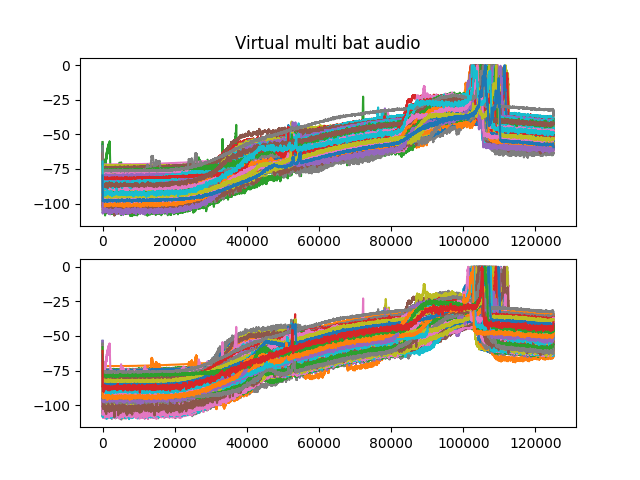

In [19]:
plt.figure()
a0 = plt.subplot(211)
a0.set_title('Virtual multi bat audio')
plot_smoothened_spectra_overlay(virtual_multibat_spectra)
a1 = plt.subplot(212, sharex=a0, sharey=a0)
plot_smoothened_spectra_overlay(single_bat_spectra)


In [43]:
freqs,spec = single_bat_spectra[15]
medIdx = np.argwhere(spec==np.percentile(spec,25))
power_baseline = float(spec[medIdx])
plus_X_freq = freqs[np.argwhere(spec>=power_baseline+40)[0]]
print(power_baseline, plus_X_freq)

-37.02316365252551 [89616.]


In [41]:
np.argwhere(spec>=float(power_baseline)+40)

array([[133194],
       [133196],
       [133197],
       ...,
       [172686],
       [172687],
       [172690]])

In [17]:
print(f'Notebook run finished at {datetime.datetime.now()}')

Notebook run finished at 2020-09-10 14:20:11.172729
